In [18]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import earthpy as et
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Spatial subsetting for netcdf files
import regionmask

# Plotting options
sns.set(font_scale = 1.3, style = 'white')

# Set working directory
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

# Get the netcdf file
data_path_monthly = 'http://thredds.northwestknowledge.net:8080/thredds/dodsC/agg_macav2metdata_tasmax_BNU-ESM_r1i1p1_rcp45_2006_2099_CONUS_monthly.nc'
monthly_forecast_temp_xr = xr.open_dataset(data_path_monthly)

# Get the AOI
url = ("https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_1_states_provinces_lakes.zip")
states_gdf = gpd.read_file(url)
states_gdf.head()

,featurecla,scalerank,adm1_code,diss_me,iso_3166_2,wikipedia,iso_a2,adm0_sr,name,name_alt,...,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,FCLASS_TLC,geometry
0,Admin-1 scale rank,2,AUS-2651,2651,AU-WA,None,AU,6,Western Australia,None,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((113.13181 -25.95199, 113.14823..."
1,Admin-1 scale rank,2,AUS-2650,2650,AU-NT,None,AU,6,Northern Territory,None,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((129.00196 -25.99901, 129.00196..."
2,Admin-1 scale rank,2,AUS-2655,2655,AU-SA,None,AU,3,South Australia,None,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((129.00196 -31.69266, 129.00196..."
3,Admin-1 scale rank,2,AUS-2657,2657,AU-QLD,None,AU,5,Queensland,None,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((138.00196 -25.99901, 138.00174..."
4,Admin-1 scale rank,2,AUS-2660,2660,AU-TAS,None,AU,5,Tasmania,None,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((147.31246 -43.28038, 147.34238..."


In [19]:
cali_aoi = states_gdf[states_gdf.name == 'California']
cali_aoi.total_bounds

array([-124.37165376,   32.53336527, -114.12501824,   42.00076797])

In [20]:
# Get lat and lon
aoi_lat = [float(cali_aoi.total_bounds[1]), float(cali_aoi.total_bounds[3])]
aoi_lon = [float(cali_aoi.total_bounds[0]), float(cali_aoi.total_bounds[2])]
aoi_lon[0] = aoi_lon[0] + 360
aoi_lon[1] = aoi_lon[1] + 360
aoi_lat, aoi_lon

([32.533365269889316, 42.00076797479207],
 [235.62834623836392, 245.87498176107795])

In [21]:
# Slice the data  by time and aoi total  bounds extent
start_date = '2010-01-15'
end_date = '2010-02-15'
two_months_cali = monthly_forecast_temp_xr.sel(time=slice(start_date, end_date),
                                               lon=slice(aoi_lon[0], aoi_lon[1]),
                                               lat=slice(aoi_lat[0], aoi_lat[1]))
two_months_cali

<xarray.Dataset> Size: 451kB
Dimensions:          (time: 2, lat: 227, lon: 246, crs: 1)
Coordinates:
  * time             (time) object 16B 2010-01-15 00:00:00 2010-02-15 00:00:00
  * lat              (lat) float64 2kB 32.56 32.6 32.65 ... 41.9 41.94 41.98
  * lon              (lon) float64 2kB 235.6 235.7 235.7 ... 245.8 245.8 245.9
  * crs              (crs) int32 4B 1
Data variables:
    air_temperature  (time, lat, lon) float32 447kB ...
Attributes: (12/46)
    description:                     Multivariate Adaptive Constructed Analog...
    id:                              MACAv2-METDATA
    naming_authority:                edu.uidaho.reacch
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    Metadata_Link:                   
    cdm_data_type:                   FLOAT
    ...                              ...
    contributor_role:                Postdoctoral Fellow
    publisher_name:                  REACCH
    publisher_email:                 reacch@uidaho.edu
    publisher_url:                   http://www.reacchpna.org/
    license:                         Creative Commons CC0 1.0 Universal Dedic...
    coordinate_system:               WGS84,EPSG:4326

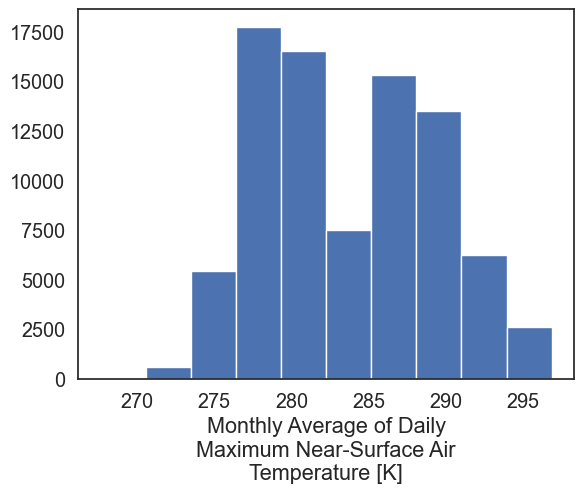

In [22]:
# Plot a quick histogram
two_months_cali['air_temperature'].plot()
plt.show()

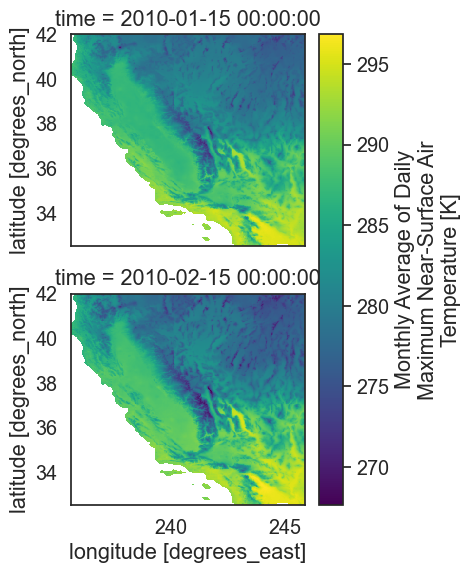

In [23]:
# Spatial plot for the aoi
two_months_cali['air_temperature'].plot(col='time',
                     col_wrap=1)
plt.show()

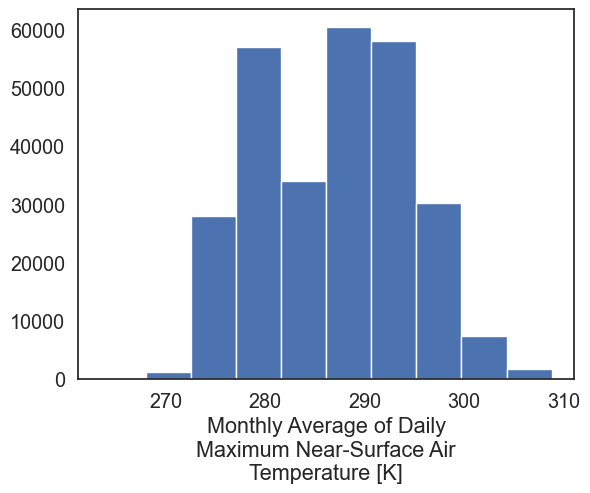

In [24]:
# Entire workflow for files netcdf4 by temporal and spatial extent (multiple regions)

# Function to get the aoi lat/lon extent
def get_aoi(shp, world=True):
    
    lon_lat = {}
    aoi_lat = [float(shp.total_bounds[1]), float(shp.total_bounds[3])]
    aoi_lon = [float(shp.total_bounds[0]), float(shp.total_bounds[2])]

    if world:
        aoi_lon[0] = aoi_lon[0] + 360
        aoi_lon[1] = aoi_lon[1] + 360
    
    lon_lat['lon'] = aoi_lon
    lon_lat['lat'] = aoi_lat
    
    return lon_lat

# Spatial extent
# Select multiple regions
cali_or_wash_nev = states_gdf[states_gdf.name.isin(['California', 'Oregon', 'Washington', 'Nevada'])]
west_bounds = get_aoi(cali_or_wash_nev)

# Create a mask for region, lon, and lat
west_mask = regionmask.mask_3D_geopandas(cali_or_wash_nev,
                                         monthly_forecast_temp_xr.lon,
                                         monthly_forecast_temp_xr.lat)

# Time extent
start_date = '2010-01-15'
end_date = '2010-04-15'

# Data subset
two_months_west_coast = monthly_forecast_temp_xr.sel(time=slice(start_date, end_date),
                                                     lon=slice(west_bounds['lon'][0], west_bounds['lon'][1]),
                                                     lat=slice(west_bounds['lat'][0], west_bounds['lat'][1])).where(west_mask)

# Plot the histogram
two_months_west_coast['air_temperature'].plot()
plt.show()

[]

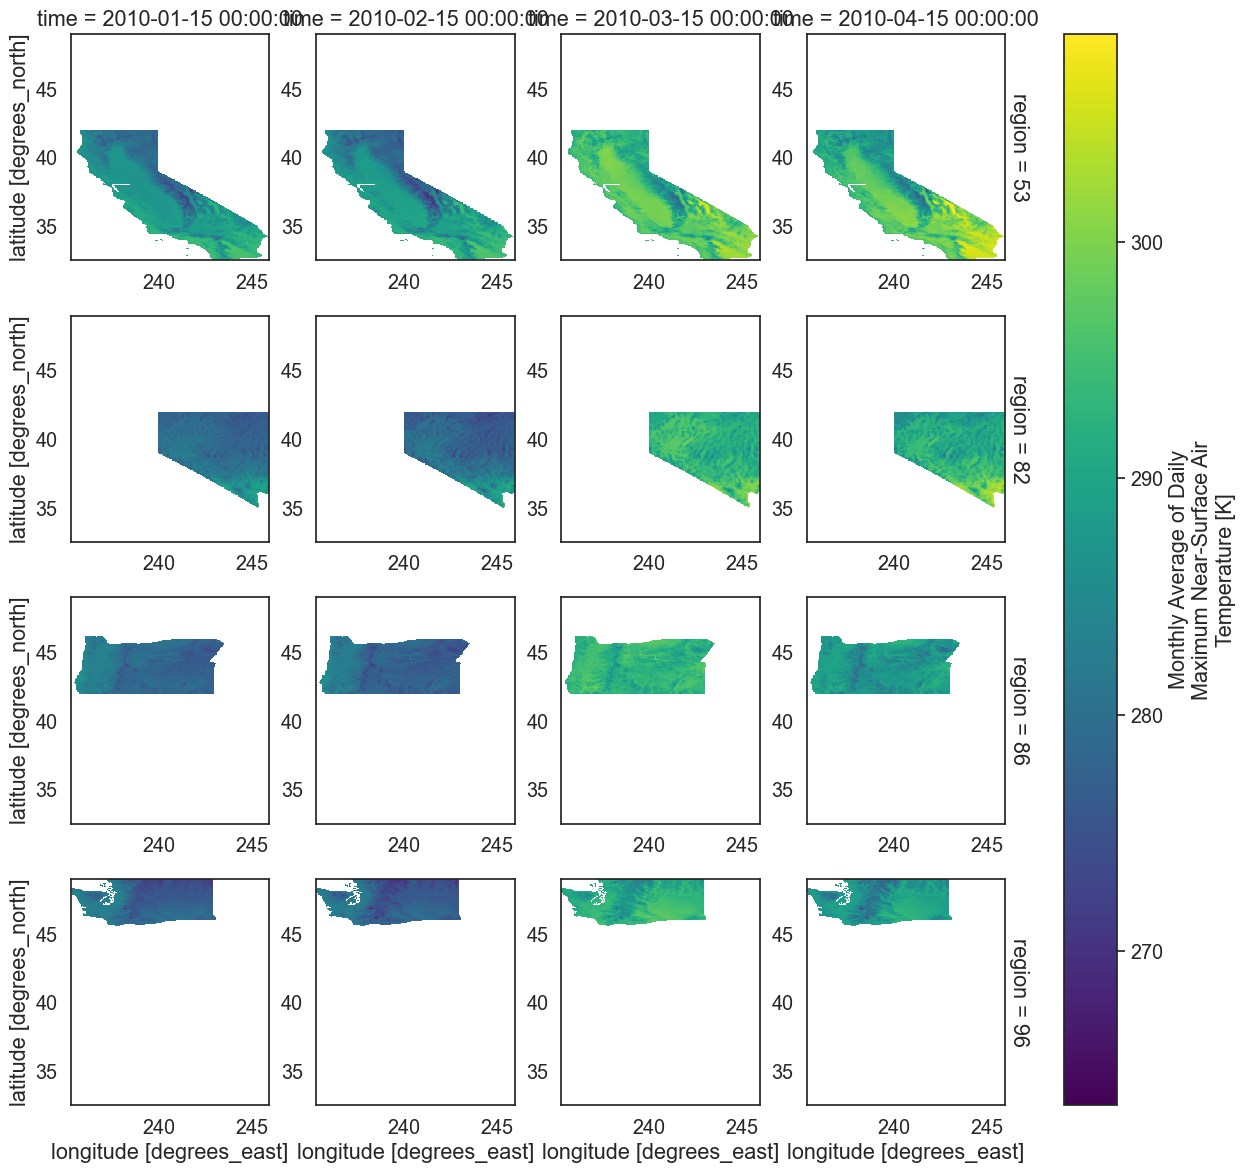

In [25]:
two_months_west_coast['air_temperature'].plot(col='time',
                           row='region',
                           sharey=False, sharex=False)
plt.plot()

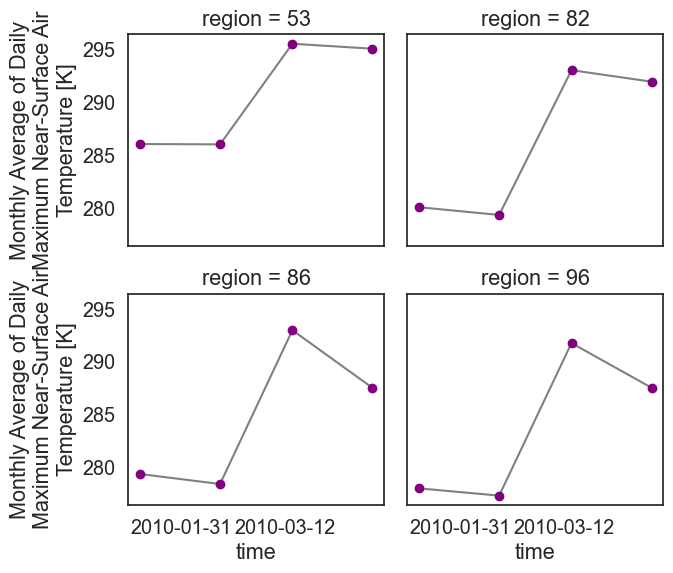

In [26]:
# Plot the mean data by region
regional_summary = two_months_west_coast.groupby('region').mean(['lat', 'lon'])
regional_summary['air_temperature'].plot(col='region',
                      col_wrap=2,
                      marker='o',
                      color='grey',
                      markerfacecolor='purple',
                      markeredgecolor='purple')
plt.show()

In [27]:
# Export to a dataframe
two_months_west_coast.groupby('region').mean(['lat', 'lon']).to_dataframe()

air_temperature
time                region crs                 
2010-01-15 00:00:00 53     1         286.057983
                    82     1         280.085175
                    86     1         279.390381
                    96     1         278.031158
2010-02-15 00:00:00 53     1         286.026550
                    82     1         279.355438
                    86     1         278.442688
                    96     1         277.346069
2010-03-15 00:00:00 53     1         295.535980
                    82     1         293.039276
                    86     1         292.983093
                    96     1         291.764526
2010-04-15 00:00:00 53     1         295.067596
                    82     1         291.950958
                    86     1         287.533386
                    96     1         287.541840

In [28]:
# SEASONAL SUMMARY

# Seasonal mean temperature for California

cali_bounds = get_aoi(cali_aoi)

start_date = '2059-12-15'
end_date = '2099-12-15'

cali_temp = monthly_forecast_temp_xr['air_temperature'].sel(time=slice(start_date, end_date),
                                                            lon=slice(cali_bounds['lon'][0], cali_bounds['lon'][1]),
                                                            lat=slice(cali_bounds['lat'][0], cali_bounds['lat'][1]))
cali_temp

<xarray.DataArray 'air_temperature' (time: 481, lat: 227, lon: 246)> Size: 107MB
[26860002 values with dtype=float32]
Coordinates:
  * time     (time) object 4kB 2059-12-15 00:00:00 ... 2099-12-15 00:00:00
  * lat      (lat) float64 2kB 32.56 32.6 32.65 32.69 ... 41.85 41.9 41.94 41.98
  * lon      (lon) float64 2kB 235.6 235.7 235.7 235.8 ... 245.8 245.8 245.9
Attributes:
    long_name:      Monthly Average of Daily Maximum Near-Surface Air Tempera...
    units:          K
    grid_mapping:   crs
    standard_name:  air_temperature
    height:         2 m
    cell_methods:   time: maximum(interval: 24 hours);mean over days
    _ChunkSizes:    [ 10  44 107]

In [29]:
print('The start date is:', cali_temp.time.min().values)
print('The end date is:', cali_temp.time.max().values)

The start date is: 2059-12-15 00:00:00
The end date is: 2099-12-15 00:00:00


In [41]:
# Mask to get only California
cali_mask = regionmask.mask_3D_geopandas(cali_aoi,
                                         monthly_forecast_temp_xr.lon,
                                         monthly_forecast_temp_xr.lat)
cali_temp_masked = cali_temp.where(cali_mask)
cali_temp_masked.dims

('time', 'lat', 'lon', 'region')

In [15]:
# Calculate the mean seasonal temperature for California
cali_season_summary = cali_temp_masked.groupby('time.season').mean('time', skipna=True)
cali_season_summary.shape

(4, 227, 246, 1)

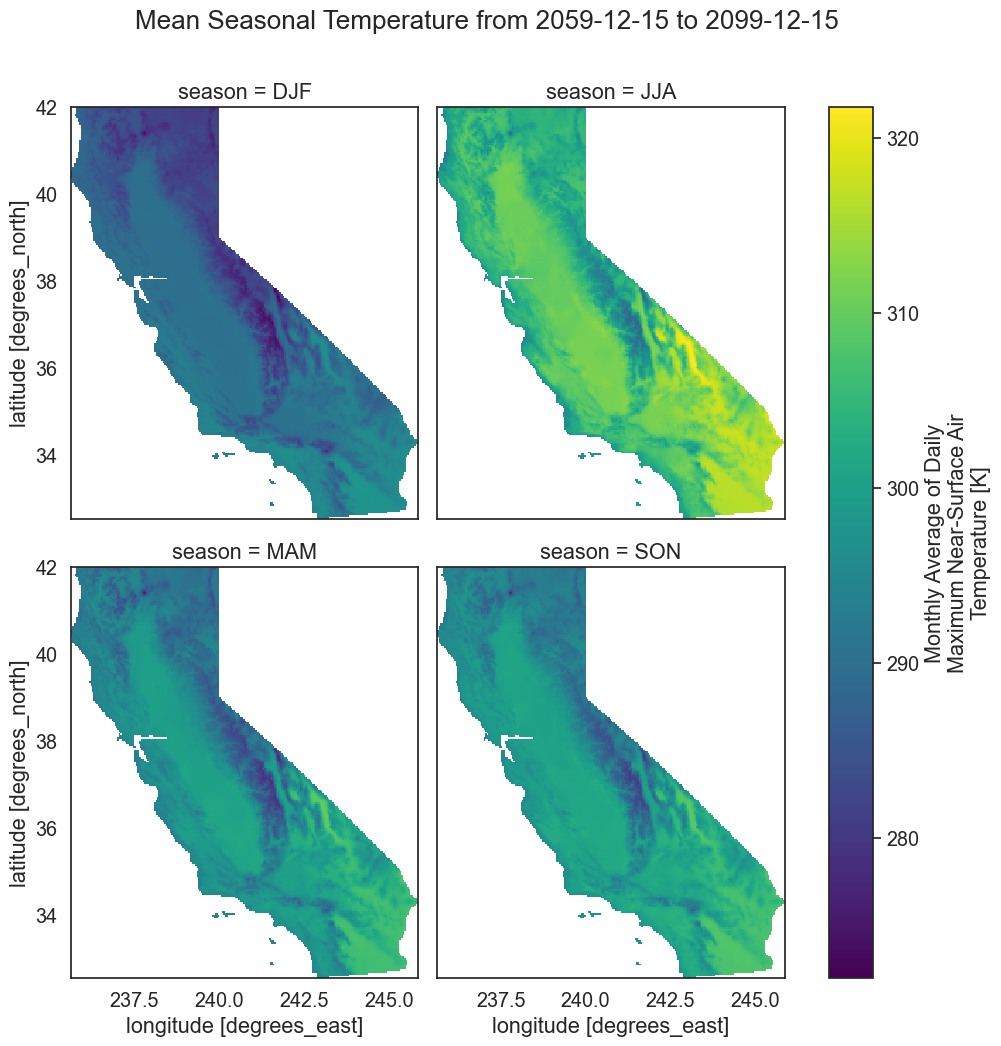

In [31]:
# Plot the mean seasonal temperature for California
cali_season_summary.plot(col='season', col_wrap=2, figsize=(10, 10))
plt.suptitle('Mean Seasonal Temperature from 2059-12-15 to 2099-12-15', y=1.05)
plt.show()

In [42]:
# Calculate UnWeighted Seasonal Avarages by Season across each year

# Resample the data for each year by quarterly periods (seasons) that starts in December, making the mean of the values for each period
cali_season_mean_all_years = cali_temp_masked.resample(time='QS-DEC').mean(dim='time', skipna=True)
cali_season_mean_all_years.shape


(161, 227, 246, 1)

In [43]:
cali_seasonal_mean = cali_season_mean_all_years.groupby('time').mean(['lat', 'lon'])
cali_seasonal_mean.shape

(161, 1)

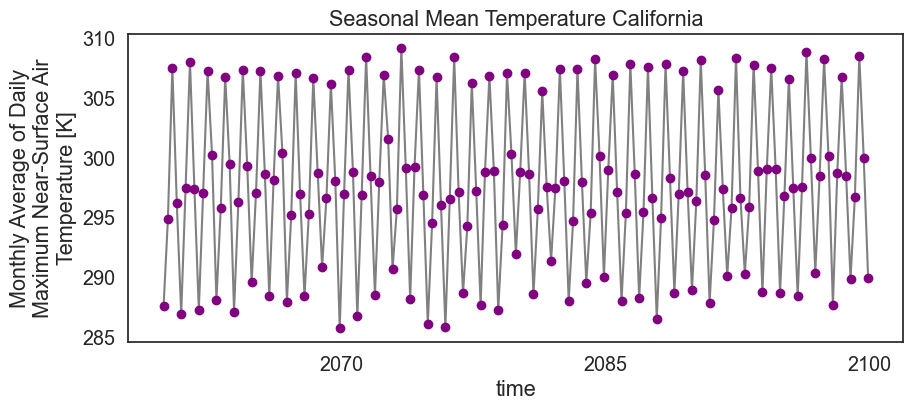

In [45]:
# Plot the data
f, ax = plt.subplots(figsize=(10, 4))
cali_seasonal_mean.plot(marker='o',
                        color='grey',
                        markerfacecolor='purple',
                        markeredgecolor='purple')
ax.set(title='Seasonal Mean Temperature California')
plt.show()

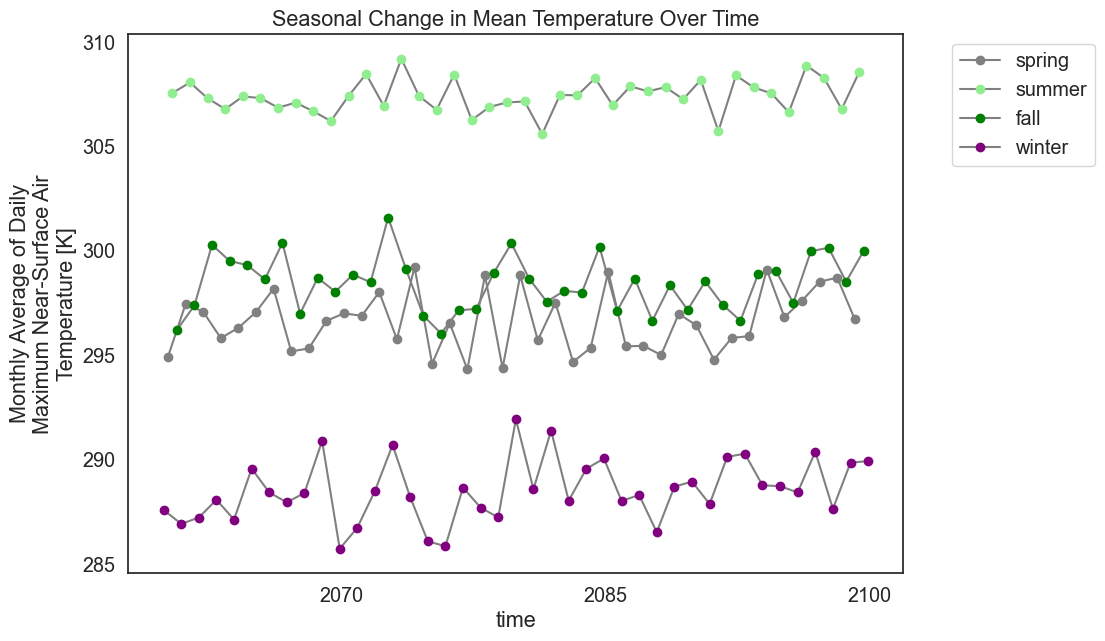

In [59]:
# Plot for each season
colors = {3: 'grey', 6:'lightgreen', 9:'green', 12:'purple'}
seasons = {3:'spring', 6:'summer', 9:'fall', 12:'winter'}
f, ax = plt.subplots(figsize=(10, 7))
for month, arr in cali_seasonal_mean.groupby('time.month'):
    arr.plot(ax=ax,
             marker='o',
             color='grey',
             markerfacecolor=colors[month],
             markeredgecolor=colors[month],
             label=seasons[month])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set(title='Seasonal Change in Mean Temperature Over Time')
plt.show()

In [49]:
# Exportar los datos en un .csv
cali_seasonal_mean_df = cali_seasonal_mean.to_dataframe()
cali_seasonal_mean_df.to_csv('cali-seasonal-temp.csv')

In [ ]:
# Weighted Summary by Season

# Calculate the number of days per month
month_lenght = cali_temp_masked.time.dt.days_in_month

# Weighted mean
cali_weighted_mean = ((cali_temp_masked * month_lenght).resample(time='QS-DEC').sum() / month_lenght.resample(time='QS-DEC').sum())
# Convert the 0 into Nan
cali_weighted_mean = cali_weighted_mean.where(cali_weighted_mean)
# Seasonal values for California
cali_weighted_seasonal_value = cali_weighted_mean.groupby('time').mean(['lat', 'lon'])
cali_weighted_seasonal_value.shape

(161, 1)

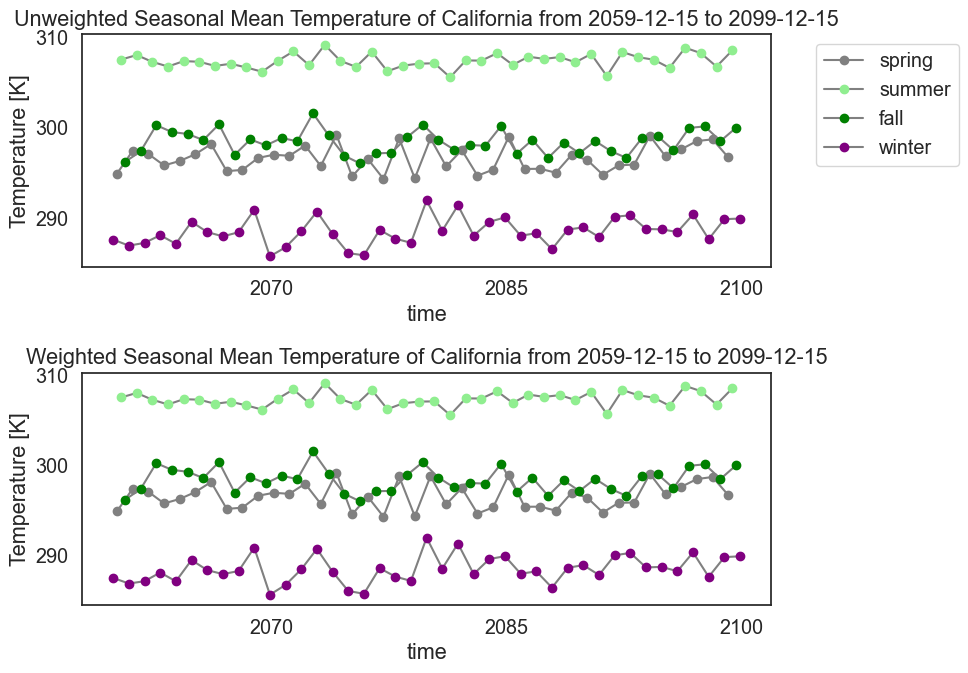

In [58]:
# Plot the data by season compared with the UnWeighted ones
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 7), sharey=False)
for month, arr in cali_seasonal_mean.groupby('time.month'):
    arr.plot(ax=ax1,
             marker='o',
             color='grey',
             markerfacecolor=colors[month],
             markeredgecolor=colors[month],
             label=seasons[month])
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.set_title(f'Unweighted Seasonal Mean Temperature of California from {start_date} to {end_date}')
ax1.set_ylabel('Temperature [K]')
for month, arr in cali_weighted_seasonal_value.groupby('time.month'):
    arr.plot(ax=ax2,
             marker='o',
             color='grey',
             markerfacecolor=colors[month],
             markeredgecolor=colors[month],
             label=seasons[month])
ax2.set_title(f'Weighted Seasonal Mean Temperature of California from {start_date} to {end_date}')
ax2.set_ylabel('Temperature [K]')
f.tight_layout()
plt.show()

In [65]:
# Same analysis for the West Coast

#Get the west coast data
west_temp_masked = monthly_forecast_temp_xr.sel(time=slice(start_date, end_date),
                                                     lon=slice(west_bounds['lon'][0], west_bounds['lon'][1]),
                                                     lat=slice(west_bounds['lat'][0], west_bounds['lat'][1])).where(west_mask)

# Get the unweighted seasonal mean
west_temp_seasonal_mean = west_temp_masked.resample(time='QS-DEC').mean(dim='time', skipna=True)
# Get the unweighted seasonal mean value for each region
west_temp_seasonal_mean_value = west_temp_seasonal_mean.groupby('time').mean(['lat', 'lon'])

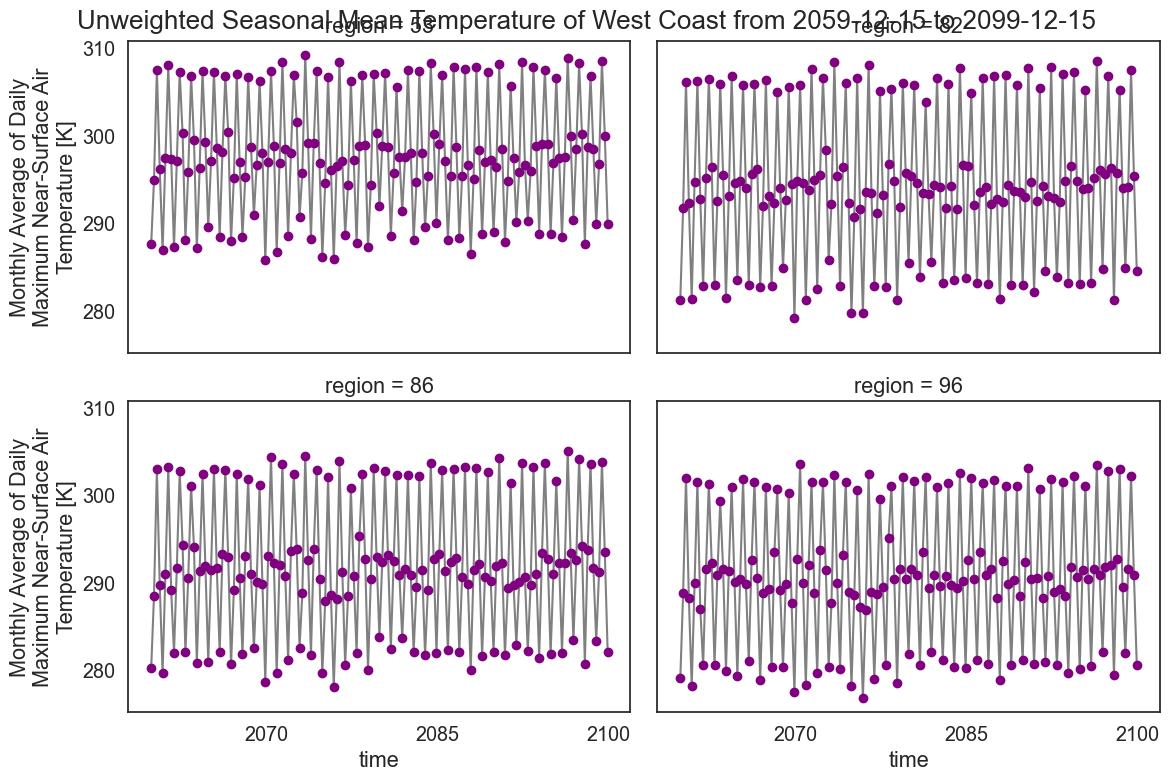

In [67]:

# Plot unwighted data
west_temp_seasonal_mean_value['air_temperature'].plot(col='region', 
                                   col_wrap=2, 
                                   marker='o', 
                                   color='grey', 
                                   markerfacecolor='purple', 
                                   markeredgecolor='purple', 
                                   figsize=(12, 8))
plt.suptitle(f'Unweighted Seasonal Mean Temperature of West Coast from {start_date} to {end_date}')
plt.show()

In [68]:
# Convert data to a dataframe
west_temp_seasonal_mean_value.to_dataframe()

air_temperature
time                region crs                 
2059-12-01 00:00:00 53     1         287.588501
                    82     1         281.238770
                    86     1         280.193817
                    96     1         279.038940
2060-03-01 00:00:00 53     1         294.914917
...                                         ...
2099-09-01 00:00:00 96     1         290.840363
2099-12-01 00:00:00 53     1         289.929535
                    82     1         284.486908
                    86     1         282.051971
                    96     1         280.577484

[644 rows x 1 columns]